In [1]:
import numpy as np

import cv2
import matplotlib.pyplot as plt
import pandas as pd

import scipy
from scipy.interpolate import CubicSpline, lagrange
from scipy.optimize import curve_fit

from numpy.polynomial.polynomial import Polynomial
import random
import os
from skimage.draw import line
from scipy.ndimage import gaussian_filter1d

import torch
from torch.distributions.gamma import Gamma

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from all import *
from transform import *
from draw import *

cpu


/home/sasha/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
circle2 = simulate_circle(w=5)

cv2.imwrite('circle.png', np.clip(circle2, 0, 255))


True

In [48]:
def simulate_squares(radius=50):
    image_border = np.zeros((200, 1250), dtype=np.float32)
    center_coordinates1 = (100, 100)
    center_coordinates2 = (250, 100)
    center_coordinates3 = (400, 100)
    center_coordinates4 = (550, 100)
    center_coordinates5 = (700, 100)
    center_coordinates6 = (850, 100)
    center_coordinates7 = (1000, 100)
    center_coordinates8 = (1150, 100)



    radius = radius

    color_border = (128, 0, 0)
    color_hole = (255, 0, 0)
    
    thickness_border = -1
    thickness_hole = -1

    # border 3
    image_border = cv2.rectangle(image_border, (center_coordinates1[0] - (radius+3), center_coordinates1[1]-(radius+3)), 
                  (center_coordinates1[0] + (radius+3), center_coordinates1[1]+ (radius+3)), color_border, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates1[0] - (radius+3), center_coordinates1[1]-(radius+3)), 
                  (center_coordinates1[0] + (radius+3), center_coordinates1[1]+ (radius+3)), color_border, thickness_border)
    image_border = cv2.rectangle(image_border, (center_coordinates1[0] - (radius), center_coordinates1[1]-(radius)), 
                  (center_coordinates1[0] + (radius), center_coordinates1[1]+ (radius)), color_hole, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates1[0] - (radius), center_coordinates1[1]-(radius)), 
                  (center_coordinates1[0] + (radius), center_coordinates1[1]+ (radius)), color_hole, thickness_hole)


    # # border 4
    image_border = cv2.rectangle(image_border, (center_coordinates2[0] - (radius+4), center_coordinates2[1]-(radius+4)), 
                  (center_coordinates2[0] + (radius+4), center_coordinates2[1]+ (radius+4)), color_border, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates2[0] - (radius+4), center_coordinates2[1]-(radius+4)), 
                  (center_coordinates2[0] + (radius+4), center_coordinates2[1]+ (radius+4)), color_border, thickness_border)
    image_border = cv2.rectangle(image_border, (center_coordinates2[0] - (radius), center_coordinates2[1]-(radius)), 
                  (center_coordinates2[0] + (radius), center_coordinates2[1]+ (radius)), color_hole, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates2[0] - (radius), center_coordinates2[1]-(radius)), 
                  (center_coordinates2[0] + (radius), center_coordinates2[1]+ (radius)), color_hole, thickness_hole)

    # # border 5
    image_border = cv2.rectangle(image_border, (center_coordinates3[0] - (radius+5), center_coordinates3[1]-(radius+5)), 
                  (center_coordinates3[0] + (radius+5), center_coordinates3[1]+ (radius+5)), color_border, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates3[0] - (radius+5), center_coordinates3[1]-(radius+5)), 
                  (center_coordinates3[0] + (radius+5), center_coordinates3[1]+ (radius+5)), color_border, thickness_border)
    image_border = cv2.rectangle(image_border, (center_coordinates3[0] - (radius), center_coordinates3[1]-(radius)), 
                  (center_coordinates3[0] + (radius), center_coordinates3[1]+ (radius)), color_hole, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates3[0] - (radius), center_coordinates3[1]-(radius)), 
                  (center_coordinates3[0] + (radius), center_coordinates3[1]+ (radius)), color_hole, thickness_hole)

    # # border 6
    image_border = cv2.rectangle(image_border, (center_coordinates4[0] - (radius+6), center_coordinates4[1]-(radius+6)), 
                  (center_coordinates4[0] + (radius+6), center_coordinates4[1]+ (radius+6)), color_border, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates4[0] - (radius+6), center_coordinates4[1]-(radius+6)), 
                  (center_coordinates4[0] + (radius+6), center_coordinates4[1]+ (radius+6)), color_border, thickness_border)
    image_border = cv2.rectangle(image_border, (center_coordinates4[0] - (radius), center_coordinates4[1]-(radius)), 
                  (center_coordinates4[0] + (radius), center_coordinates4[1]+ (radius)), color_hole, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates4[0] - (radius), center_coordinates4[1]-(radius)), 
                  (center_coordinates4[0] + (radius), center_coordinates4[1]+ (radius)), color_hole, thickness_hole)

    # # border 7
    image_border = cv2.rectangle(image_border, (center_coordinates5[0] - (radius+7), center_coordinates5[1]-(radius+7)), 
                  (center_coordinates5[0] + (radius+7), center_coordinates5[1]+ (radius+7)), color_border, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates5[0] - (radius+7), center_coordinates5[1]-(radius+7)), 
                  (center_coordinates5[0] + (radius+7), center_coordinates5[1]+ (radius+7)), color_border, thickness_border)
    image_border = cv2.rectangle(image_border, (center_coordinates5[0] - (radius), center_coordinates5[1]-(radius)), 
                  (center_coordinates5[0] + (radius), center_coordinates5[1]+ (radius)), color_hole, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates5[0] - (radius), center_coordinates5[1]-(radius)), 
                  (center_coordinates5[0] + (radius), center_coordinates5[1]+ (radius)), color_hole, thickness_hole)

    # # border 8
    image_border = cv2.rectangle(image_border, (center_coordinates6[0] - (radius+8), center_coordinates6[1]-(radius+8)), 
                  (center_coordinates6[0] + (radius+8), center_coordinates6[1]+ (radius+8)), color_border, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates6[0] - (radius+8), center_coordinates6[1]-(radius+8)), 
                  (center_coordinates6[0] + (radius+8), center_coordinates6[1]+ (radius+8)), color_border, thickness_border)
    image_border = cv2.rectangle(image_border, (center_coordinates6[0] - (radius), center_coordinates6[1]-(radius)), 
                  (center_coordinates6[0] + (radius), center_coordinates6[1]+ (radius)), color_hole, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates6[0] - (radius), center_coordinates6[1]-(radius)), 
                  (center_coordinates6[0] + (radius), center_coordinates6[1]+ (radius)), color_hole, thickness_hole)

    # # border 9
    image_border = cv2.rectangle(image_border, (center_coordinates7[0] - (radius+9), center_coordinates7[1]-(radius+9)), 
                  (center_coordinates7[0] + (radius+9), center_coordinates7[1]+ (radius+9)), color_border, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates7[0] - (radius+9), center_coordinates7[1]-(radius+9)), 
                  (center_coordinates7[0] + (radius+9), center_coordinates7[1]+ (radius+9)), color_border, thickness_border)
    image_border = cv2.rectangle(image_border, (center_coordinates7[0] - (radius), center_coordinates7[1]-(radius)), 
                  (center_coordinates7[0] + (radius), center_coordinates7[1]+ (radius)), color_hole, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates7[0] - (radius), center_coordinates7[1]-(radius)), 
                  (center_coordinates7[0] + (radius), center_coordinates7[1]+ (radius)), color_hole, thickness_hole)

    # # border 10
    image_border = cv2.rectangle(image_border, (center_coordinates8[0] - (radius+10), center_coordinates8[1]-(radius+10)), 
                  (center_coordinates8[0] + (radius+10), center_coordinates8[1]+ (radius+10)), color_border, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates8[0] - (radius+10), center_coordinates8[1]-(radius+10)), 
                  (center_coordinates8[0] + (radius+10), center_coordinates8[1]+ (radius+10)), color_border, thickness_border)
    image_border = cv2.rectangle(image_border, (center_coordinates8[0] - (radius), center_coordinates8[1]-(radius)), 
                  (center_coordinates8[0] + (radius), center_coordinates8[1]+ (radius)), color_hole, 2) 
    image_border = cv2.rectangle(image_border, (center_coordinates8[0] - (radius), center_coordinates8[1]-(radius)), 
                  (center_coordinates8[0] + (radius), center_coordinates8[1]+ (radius)), color_hole, thickness_hole)
    plt.imshow(image_border, cmap='gray')
    plt.show()

    # cv2.imwrite('./data/test_img_two.png', image_border)
    return image_border

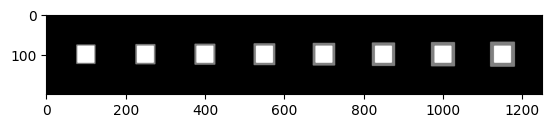

In [49]:
img_squares = simulate_squares(radius=20)

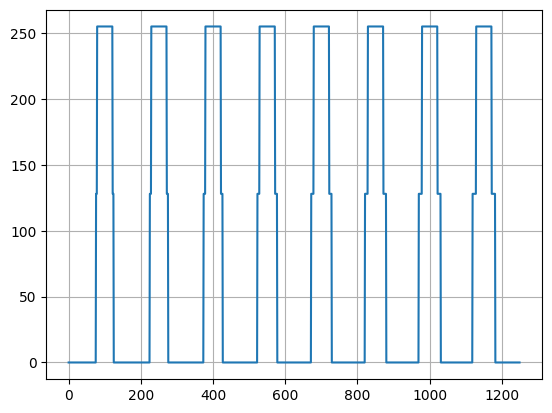

In [53]:
plt.plot(np.arange(0, img_squares.shape[1]), img_squares[100, :])
plt.grid()

In [54]:
img_squares[70:170, 100]

array([  0.,   0.,   0.,   0.,   0.,   0., 128., 128., 128., 255., 255.,
       255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
       255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
       255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
       255., 255., 255., 255., 255., 255., 255., 255., 128., 128., 128.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.], dtype=float32)

In [18]:
ext, int, circle2 = detect_contours(circle2)
width_img= transform(circle2, ext, int)

plt.imshow(width_img)
# signal_second = formula_second(circle2, new_angles, color_map, 0.3,'signal_circles.png', './')

NameError: name 'circle2' is not defined

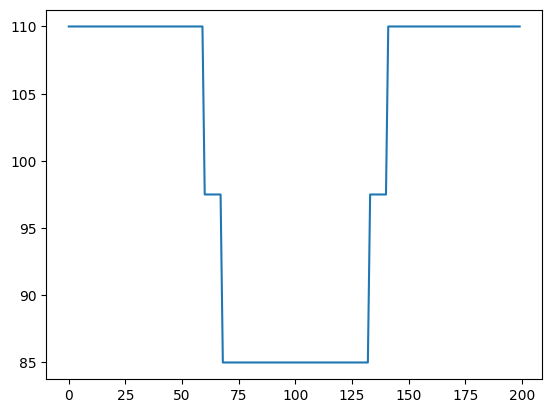

In [4]:
patch = circle2[60:61, :]

patch[patch == 0] = 110
patch[patch==255] = 85
patch[patch==128] = (110+85)/2

plt.plot(np.arange(0, patch.shape[1]), patch[0])

In [5]:
patch

array([[110. , 110. , 110. , 110. , 110. , 110. , 110. , 110. , 110. ,
        110. , 110. , 110. , 110. , 110. , 110. , 110. , 110. , 110. ,
        110. , 110. , 110. , 110. , 110. , 110. , 110. , 110. , 110. ,
        110. , 110. , 110. , 110. , 110. , 110. , 110. , 110. , 110. ,
        110. , 110. , 110. , 110. , 110. , 110. , 110. , 110. , 110. ,
        110. , 110. , 110. , 110. , 110. , 110. , 110. , 110. , 110. ,
        110. , 110. , 110. , 110. , 110. , 110. ,  97.5,  97.5,  97.5,
         97.5,  97.5,  97.5,  97.5,  97.5,  85. ,  85. ,  85. ,  85. ,
         85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,
         85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,
         85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,
         85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,
         85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,
         85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,  85. ,
      

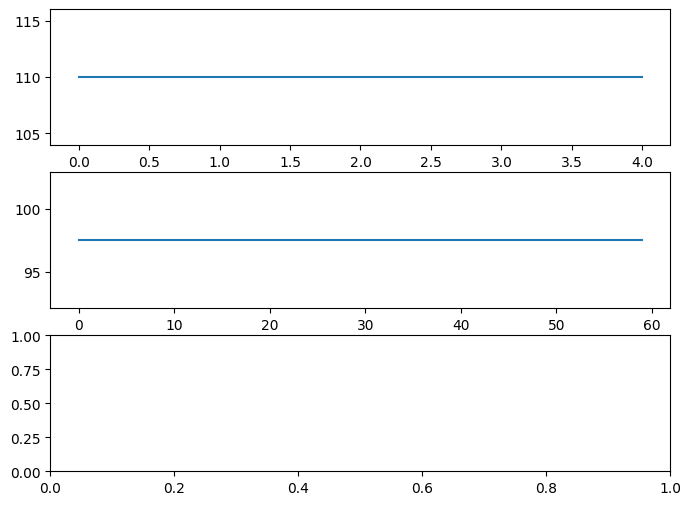

In [6]:
line = patch[0, 4:9]

new_line = np.zeros(len(line)*12, dtype=np.float32)
new_line[new_line == 0] = 97.5

fig, ax = plt.subplots(3, 1, figsize=(8, 6))
ax[0].plot(np.arange(0, len(line)), line)
ax[1].plot(np.arange(0, len(new_line)), new_line)

In [113]:
df = pd.DataFrame(columns=['line width', 'max value slice', 'angles values slice', 'max value', 'angles values'])
df

,line width,max value slice,angles values slice,max value,angles values


In [12]:
# line = [97.5, 97.5, 97.5, 97.5]
line = [0] * 50


new_line = np.zeros(len(line)*12, dtype=np.float32)
# new_line[new_line == 0] = 97.5


455 86.06787403382245
502 90.32326937629709
y :  [110.         109.9999498  109.99979907 109.99954762 109.99919524
 109.99874175 109.99818695 109.99753064 109.99677263 109.99591272
 109.99495072 109.99388643 109.99271966 109.99145021 109.99007788
 109.98860248 109.98702382 109.9853417  109.98355592 109.98166629
 109.97967261 109.97757469 109.97537233 109.97306533 109.97065351
 109.96813667 109.9655146  109.96278712 109.95995403 109.95701513
 109.95397023 109.95081914 109.94756165 109.94419758 109.94072672
 109.93714888 109.93346387 109.92967149 109.92577155 109.92176385
 109.91764819 109.91342438 109.90909222 109.90465152 109.90010208
 109.89544371 109.89067622 109.8857994  109.88081306 109.875717
 109.87051104 109.86519497 109.8597686  109.85423174 109.84858418
 109.84282574 109.83695621 109.83097541 109.82488313 109.81867919
 109.81236338 109.80593551 109.79939539 109.79274282 109.7859776
 109.77909954 109.77210844 109.76500411 109.75778636 109.75045498
 109.74300978 109.73545057 109

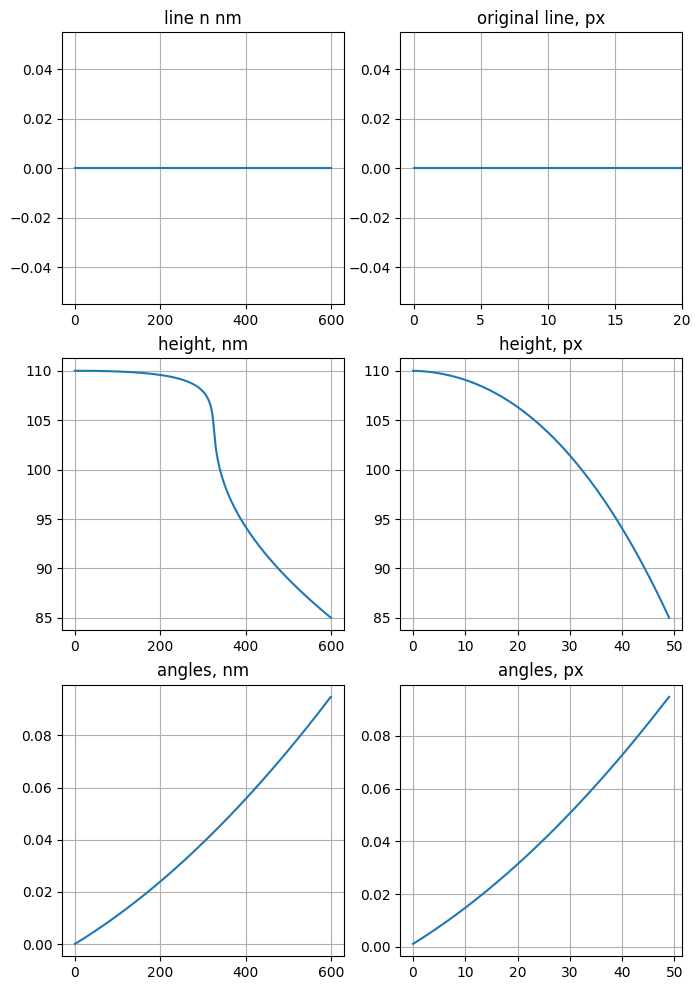

In [14]:
def bezier(line, t, prev, color_hole, color_back):
    if prev == 0:
        point1 = (0, color_back)
        point4 = (len(line), color_hole)
        eq = lambda point: ((point - point1[0])/(point4[0] - point1[0]))*(point4[1] - point1[1]) + point1[1]
        x3 = random.randint(0, len(line)-1)
        y3 = random.uniform(color_hole, eq(x3))
        print(x3, y3)
        point3 = (0, color_hole)
        point3 = (66, 104)

        # point3 = (x3, y3)
        x2 = random.randint(1, len(line))
        y2 = random.uniform(eq(x2)+1,color_back)
        print(x2, y2)
        point2 = (x2, y2)
        point2 = (len(line), color_back)
        # point2 = (66, 546)

    if prev == 255:
        point1 = (0, color_hole)
        point4 = (len(line), color_back)
        eq = lambda point: ((point - point1[0])/(point4[0] - point1[0]))*(point4[1] - point1[1]) + point1[1]
        x3 = random.randint(0, len(line)-1)
        y3 = random.uniform(eq(x3), color_back+1)
        print(x3, y3)
        point3 = (0, color_back)
        # point3 = (66, 546)
        x2 = random.randint(1, len(line))
        y2 = random.uniform(color_hole, eq(x2))
        print(x2, y2)
        point2 = (x2, y2)
        point2 = (len(line), color_hole)

    # point2 = (len(line), 97.5)
    # point2 = (x2, y2)


    x = point1[0]*(1-t)**3 + point2[0]*3*t*(1-t)**2 + point3[0]*3*t**2*(1-t) + point4[0]*t**3
    vals = point1[1]*(1-t)**3 + point2[1]*3*t*(1-t)**2 + point3[1]*3*t**2*(1-t) + point4[1]*t**3
    # print(vals)
    return x, vals

x, y = bezier(new_line, np.linspace(0, 1, len(new_line)), 0, 85, 110)

fig, ax = plt.subplots(3, 2, figsize=(8, 12))
ax[0, 0].plot(np.arange(0, len(new_line)), new_line)
ax[0, 0].set_title('line n nm')
ax[0, 0].grid()

ax[0, 1].plot(np.arange(0, len(line)), line)
ax[0, 1].set_title('original line, px')
ax[0, 1].grid()
ax[0, 1].set_xlim(-1, 20)




ax[1, 0].plot(x, y)
ax[1, 0].set_title('height, nm')
ax[1, 0].grid()



# y_new = y[0::12]
reshaped_y  = np.array(y).reshape(-1, 12)  # Разбиваем на подмассивы по 12 элементов
# averages_angls = np.max(reshaped_angls, axis=1)
averages_y = np.max(reshaped_y, axis=1)
# averages_y = np.mean(reshaped_y, axis=1)
# y_new  = gaussian_filter1d(y_new, sigma=3)

# ax[1, 1].plot(np.arange(0, len(line)), y_new)
# ax[1, 1].plot(np.arange(0, len(line)), averages_y)

# ax[1, 1].set_title('height, px')


# angles = np.arctan(np.abs(np.gradient(y, x)))
print('y : ', y)
angles = np.arctan(np.abs(np.gradient(y)))

print(angles)
reshaped_angls  = np.array(angles).reshape(-1, 12)  # Разбиваем на подмассивы по 12 элементов
averages_angls = np.max(reshaped_angls, axis=1)
max_indices = np.argmax(reshaped_angls, axis=1)

averages_y = reshaped_y[np.arange(len(reshaped_y)), max_indices]

ax[1, 1].plot(np.arange(0, len(line)), averages_y)

ax[1, 1].set_title('height, px')
ax[1, 1].grid()
# ax[1, 1].set_xlim(-1, 20)


# averages_angls = np.mean(reshaped_angls, axis=1)

# averages_colors = reshaped_colors[np.arange(len(array1)), max_indices]

print(averages_angls)

# if len(line) not in df['line width'].values:
#     df.loc[len(df.index)] = [len(line), angles[0::12].max(), angles[0::12], averages_angls.max(), averages_angls]

# ax[4].plot(np.arange(0, len(line)+1), np.array(list(angles[0::12]) + [0]))
ax[2, 0].plot(np.arange(0, len(new_line)), angles)
ax[2, 0].set_title('angles, nm')
ax[2, 0].grid()


print(angles[0::12])
ax[2, 1].plot(np.arange(0, len(line)), averages_angls)
ax[2, 1].set_title('angles, px')
ax[2, 1].grid()
# ax[2, 1].set_xlim(-1, 20)





# ax[3, 0].plot(np.arange(0, len(new_line)), angles)
# ax[3, 0].set_title('angles, nm')

# ax[3, 1].plot(np.arange(0, len(line)), angles[::12])
# ax[3, 1].set_title('angles, px')


In [131]:
df

,line width,max value slice,angles values slice,max value,angles values
0,3,1.527620,"[0.9642636666225616, 1.5276198314060991, 1.525...",1.531853,"[1.525657392493737, 1.5318529214637566, 1.5256..."
1,4,1.518566,"[0.6767439534475468, 1.502183653793687, 1.5185...",1.518566,"[1.4980360625595048, 1.518566430307763, 1.5185..."
2,5,1.502957,"[0.4726069976204859, 1.4699280093024982, 1.502...",1.505291,"[1.4630976944830623, 1.5019767993819015, 1.505..."
3,6,1.492034,"[0.33998430631071197, 1.4312203467076274, 1.48...",1.492034,"[1.4212100608726326, 1.4809575117120473, 1.492..."
4,7,1.477181,"[0.25360678467805614, 1.386421523538427, 1.459...",1.478803,"[1.3727979382228364, 1.4561790827747045, 1.476..."
5,8,1.465603,"[0.195516358395544, 1.3360114701436971, 1.4319...",1.465603,"[1.318451028257785, 1.4279310989242027, 1.4578..."
6,9,1.451197,"[0.15498640784076761, 1.2806363088246748, 1.40...",1.452439,"[1.258966925496738, 1.3964216753123264, 1.4365..."
7,10,1.439315,"[0.12573082439087463, 1.2211230212364956, 1.36...",1.439315,"[1.195357119366127, 1.3618571336090948, 1.4128..."


In [110]:
y


array([700.        , 698.55860058, 694.34635569, 687.53119534,
       678.28104956, 666.7638484 , 653.14752187, 637.6       ,
       620.28921283, 601.38309038, 581.04956268, 559.45655977,
       536.77201166, 513.1638484 , 488.8       , 463.8483965 ,
       438.47696793, 412.85364431, 387.14635569, 361.52303207,
       336.1516035 , 311.2       , 286.8361516 , 263.22798834,
       240.54344023, 218.95043732, 198.61690962, 179.71078717,
       162.4       , 146.85247813, 133.2361516 , 121.71895044,
       112.46880466, 105.65364431, 101.44139942, 100.        ])

In [111]:
x

array([ 0.        ,  2.91274636,  5.49299125,  7.7608863 ,  9.73658309,
       11.44023324, 12.89198834, 14.112     , 15.12041983, 15.93739942,
       16.58309038, 17.07764431, 17.44121283, 17.69394752, 17.856     ,
       17.94752187, 17.98866472, 17.99958017, 18.00041983, 18.01133528,
       18.05247813, 18.144     , 18.30605248, 18.55878717, 18.92235569,
       19.41690962, 20.06260058, 20.87958017, 21.888     , 23.10801166,
       24.55976676, 26.26341691, 28.2391137 , 30.50700875, 33.08725364,
       36.        ])

In [112]:
angles

array([0.96426367, 1.230781  , 1.39138026, 1.44694168, 1.47478738,
       1.49138867, 1.50232548, 1.51000392, 1.51562954, 1.51987154,
       1.52312997, 1.52565739, 1.52761983, 1.52912948, 1.5302633 ,
       1.531074  , 1.5315967 , 1.53185292, 1.53185292, 1.5315967 ,
       1.531074  , 1.5302633 , 1.52912948, 1.52761983, 1.52565739,
       1.52312997, 1.51987154, 1.51562954, 1.51000392, 1.50232548,
       1.49138867, 1.47478738, 1.44694168, 1.39138026, 1.230781  ,
       0.96426367])

In [101]:
df

,line width,max value slice,angles values slice,max value,angles values
0,3,1.558404,"[0.45952654158959017, 1.558404077357171, 1.552...",1.566284,"[1.3143177714706995, 1.566283894740497, 1.3143..."
1,4,1.570770,"[0.26712478298533643, 1.5212775321641125, 1.57...",1.554766,"[1.172885635656337, 1.5547664448183796, 1.5547..."
2,5,1.563984,"[0.17168065102208283, 1.4635150535482528, 1.56...",1.568269,"[1.0328618233902822, 1.524254746095501, 1.5682..."
3,6,1.570779,"[0.11904087167439673, 1.3867016353968358, 1.54...",1.561287,"[0.8985392477828276, 1.4783286695229656, 1.561..."
4,7,1.566057,"[0.08723580956971974, 1.2932546136273309, 1.51...",1.569029,"[0.773771123339719, 1.4185178081359806, 1.5423..."
5,8,1.570784,"[0.06662387181556338, 1.1871128481957622, 1.46...",1.563939,"[0.6614303276599446, 1.346435236606667, 1.5136..."
6,9,1.567154,"[0.05252579704752958, 1.0736907740998416, 1.41...",1.569436,"[0.5630792456909873, 1.2643240019492312, 1.476..."
7,10,1.570786,"[0.042466015900608216, 0.9590959154536478, 1.3...",1.565411,"[0.47896613558931417, 1.1750947494821522, 1.43..."


In [102]:
df.to_excel('angles_vs_width_from_height_mean.xlsx')

In [87]:
angles[::12]

array([0.02061621, 1.28169972, 1.15569456])

In [82]:
averages_angls

array([1.15569456, 1.56995709, 1.15569456])

## fix point2 and point3 in bezier

In [42]:
from skimage.draw import line

def bezier(line, t, prev, color_hole, color_back):
    if prev == 0.0:
        point1 = (0, color_back)
        point4 = (len(line), color_hole)
        eq = lambda point: ((point - point1[0])/(point4[0] - point1[0]))*(point4[1] - point1[1]) + point1[1]
        x3 = random.randint(0, len(line)-1)
        y3 = random.uniform(color_hole, eq(x3))
        # print(x3, y3)
        point3 = (0, color_hole)
        # point3 = (x3, y3)
        x2 = random.randint(1, len(line))
        y2 = random.uniform(eq(x2)+1,color_back)
        # print(x2, y2)
        # point2 = (x2, y2)
        point2 = (len(line), color_back)
    if prev == 255.0:
        # print('white')

        point1 = (0, color_hole)
        point4 = (len(line), color_back)
        eq = lambda point: ((point - point1[0])/(point4[0] - point1[0]))*(point4[1] - point1[1]) + point1[1]
        x3 = random.randint(0, len(line)-1)
        y3 = random.uniform(eq(x3), color_back+1)
        # print(x3, y3)
        point3 = (0, color_back)
        # point3 = (x3, y3)
        x2 = random.randint(1, len(line))
        y2 = random.uniform(color_hole, eq(x2))
        # print(x2, y2)
        # point2 = (x2, y2)
        point2 = (len(line), color_hole)

    # point2 = (len(line), 97.5)
    # point2 = (x2, y2)


    x = point1[0]*(1-t)**3 + point2[0]*3*t*(1-t)**2 + point3[0]*3*t**2*(1-t) + point4[0]*t**3
    vals = point1[1]*(1-t)**3 + point2[1]*3*t*(1-t)**2 + point3[1]*3*t**2*(1-t) + point4[1]*t**3

    # plt.plot(x, vals)
    # plt.set_title('original line, px')

    return x, vals

def transform1(img, ext, int):
    color_back = 110
    color_hole = 85

    width_img = np.zeros_like(img, dtype=np.float32)
    angles_img = np.zeros_like(img, dtype=np.float32)
    new_angles = np.zeros_like(img, dtype=np.float32)
    color_map = np.zeros_like(img, dtype=np.float32)
    color_map[img == 0] = color_back
    color_map[img == 255] = color_hole

    fig, ax = plt.subplots(1,1,figsize=(10, 10))
    cp = np.zeros_like(circle2)
    # cp = cv2.fillPoly(cp, [int], 2)
    # cp = cv2.fillPoly(cp, [cont_int], 2)


    count = 0
    for cont_ext, cont_int in zip(ext, int):
        # cp = cv2.fillConvexPoly(cp, cont_int, 0)
        # cp = cv2.fillConvexPoly(cp, cont_ext, 0)
        cp = cv2.fillPoly(cp, [cont_ext], 1)

        cp = cv2.fillPoly(cp, [cont_int], 2)
        # cp = cv2.fillPoly(cp, [cont_ext], 1)
        # cont_mask, _ = cv2.findContours(cp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # mask_cont = np.zeros_like(circle2)
        # cv2.drawContours(mask_cont, cont_mask,  -1, 1, 0)
        # cp = np.zeros_like(circle2, dtype=np.float32)
        # cp = cv2.fillPoly(cp, [cont_ext], 1)
        # cont_mask, _ = cv2.findContours(cp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # mask_cont = np.zeros_like(circle2)
        # cv2.drawContours(mask_cont, cont_mask,  -1, 1, 0)

        ax.imshow(cp)

        for point in cont_ext:
                min_dist = float('inf')
                index, dist = closest_point(point, cont_int)
                if dist[index] < min_dist :
                    min_dist = dist[index].item()
                    nearest_point = cont_int[index] 
                    prev = [compute_previous_pixel(point, nearest_point)]
                    
                    # if nearest_point[0] == point[0] and nearest_point[1] == point[1]:
                    #     dist_ = 1
                    # else:
                        # dist_ = np.sqrt((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1])**2).astype(np.int32)
                    # dist_ = np.sqrt((prev[0][0] - nearest_point[0])**2 + (prev[0][1] - nearest_point[1])**2).astype(np.int32)
                    
                    # print(min_dist, dist_)
                    # dist_ = dist_.item()
                    discrete_line = list(zip(*line(*prev[0], *nearest_point))) # find all pixels from the line
                    dist_ = len(discrete_line)
                # dist_ += 1
                
                if dist_ == 0:
                    dist_ = 1

                # discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
                # discrete_line = list(zip(*line(*prev[0], *nearest_point))) # find all pixels from the line

                # discrete_line_x = np.array(list(zip(*discrete_line))[0])
                # if len(discrete_line) > 1:
                #     mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
                #     prev = [compute_previous_pixel(point, nearest_point)]
                #     next = [compute_next_pixel(point, nearest_point)]
                # print(point)
                # print('color point = {:.8f}, color prev = {:.8f}, len line = {:.8f}'.format(img[point[1], point[0]], img[prev[0][1], prev[0][0]], len(discrete_line)))
                if img[prev[0][1], prev[0][0]] == 128.0:
                    # print('color point = {:.8f}, color prev = {:.8f}, len line = {:.8f}'.format(img[point[1], point[0]], img[prev[0][1], prev[0][0]], len(discrete_line)))
                    # dist += 1
                    count += 1
                    # discrete_line = prev + discrete_line

                    prev = [compute_previous_pixel(prev[0], nearest_point)]
                    # print('new prev', img[prev[0][1], prev[0][0]])
                    

                ax.scatter(point[0], point[1], color='red', s=2, alpha=0.5)
                # ax.scatter(prev[0][0], prev[0][1], color='yellow', s=0.5, alpha=0.5)
                # ax.scatter(next[0][0], next[0][1], color='green', s=0.5, alpha=0.5)
                ax.scatter(nearest_point[0], nearest_point[1], color='blue', s=2, alpha=0.5)
                # if dist_ == 7:
                ax.plot([point[0], nearest_point[0]], [point[1], nearest_point[1]], color='orange', linewidth=1)
                # ax.scatter(mid_point[0], mid_point[1], color='hotpink', s=1, alpha=0.5)

                # if img[prev[0][1], prev[0][0]] != 128.0:
                new_line = np.zeros(dist_*12, dtype=np.float32)
                # x, y = bezier(new_line, np.linspace(0, 1, len(new_line)), img[prev[0][1], prev[0][0]], color_hole, color_back)
                x, y = bezier(new_line, np.linspace(0, 1, len(new_line)), 0.0, color_hole, color_back)

                # print(y)
                new_y = y[::12]
                reshaped_y  = np.array(y).reshape(-1, 12)  # Разбиваем на подмассивы по 12 элементов
                averages_y = np.mean(reshaped_y, axis=1)
                # print(len(new_y))

                angles = np.arctan(np.abs(np.gradient(y, x)))
                new_angl = angles[::12]

                reshaped_angls  = np.array(angles).reshape(-1, 12)  # Разбиваем на подмассивы по 12 элементов
                averages_angls = np.mean(reshaped_angls, axis=1)
                # averages_angls[averages_angls < 0.1] = 0.1

                # averages_angls = np.max(reshaped_angls, axis=1)
                averages_angls[averages_angls < 0.1] = 0.1

                print(averages_angls)

                if len(averages_angls) != len(discrete_line):
                    print('dist = {:.2f}, len angls = {:.2f}, len line = {:.2f}'.format(dist_, len(averages_angls), len(discrete_line)))

                # print(angles[::12])
                # if len(x) == 120:
                #     print(y[::12], angles[::12])
                draw_gradient_line(color_map, point, discrete_line, averages_y, thickness=4)
                # draw_gradient_line(new_angles, point, discrete_line, new_angl, thickness=1)
                draw_gradient_line(new_angles, point, discrete_line, averages_angls, thickness=1)

                # else:
                #     print(point)


                # print(y)
                # angle = np.arctan(700 / (dist_ * 12))
                cv2.line(width_img, point, nearest_point, dist_, 3)
                # cv2.line(angles_img, point, nearest_point, angle, 2)

                # if len(discrete_line) == 1:
                #     height_vals = [color_back - 2]
                #     discrete_line_ = discrete_line

                # else:
                #     height_vals = [((k_ * ((color_back - color_hole) / dist_)) + color_hole) for k_ in range(0, dist_+2)]
                #     discrete_line_ = discrete_line + next

                # draw_gradient_line(color_map, point, discrete_line_, height_vals, thickness=3)


    for cont_ext, cont_int in zip(ext, int):
        for point in cont_int:
                min_dist = float('inf')
                index, dist = closest_point(point, cont_ext)
                if dist[index] < min_dist :
                    min_dist = dist[index].item()
                    nearest_point = cont_ext[index]
                    # prev = [compute_previous_pixel(point, nearest_point)]
                    next = [compute_next_pixel(point, nearest_point)]
                    discrete_line = list(zip(*line(*point, *next[0]))) # find all pixels from the line
                    dist_ = len(discrete_line)
                    # if nearest_point[0] == point[0] and nearest_point[1] == point[1]:
                    #     dist_ = 1
                    # else:
                        # dist_ = np.sqrt((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1])**2).astype(np.int32)
                    # dist_ = np.sqrt((prev[0][0] - nearest_point[0])**2 + (prev[0][1] - nearest_point[1])**2).astype(np.int32)
                    # dist_ = np.sqrt((next[0][0] - nearest_point[0])**2 + (next[0][1] - nearest_point[1])**2).astype(np.int32)
                    
                    # dist_ = dist_.item()

                # dist_ += 1
                if dist_ == 0:
                    dist_ = 1

                # print(dist_)
                # if dist_< 19:
                #     print('!!!!!!!!!!')

                # if dist_ > 10:
                #     dist_ = 10
                # discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
            
                # discrete_line_x = np.array(list(zip(*discrete_line))[0])
                # if len(discrete_line) > 1:
                #     mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
                #     prev = [compute_previous_pixel(point, nearest_point)]
                #     next = [compute_next_pixel(point, nearest_point)]

                # if img[prev[0][1], prev[0][0]] == 128.0:
                #     dist += 1
                #     discrete_line = prev + discrete_line

                #     prev = [compute_previous_pixel(prev[0], nearest_point)]

                # if img[prev[0][1], prev[0][0]] == 128.0:
                if img[next[0][1], next[0][0]] == 128.0:

                    # print('color point = {:.8f}, color prev = {:.8f}, len line = {:.8f}'.format(img[point[1], point[0]], img[prev[0][1], prev[0][0]], len(discrete_line)))
                    # dist += 1
                    count += 1
                    # discrete_line = prev + discrete_line

                    # prev = [compute_previous_pixel(prev[0], nearest_point)]
                    next = [compute_next_pixel(next[0], nearest_point)]


                new_line = np.zeros(dist_*12, dtype=np.float32)
                # x, y = bezier(new_line, np.linspace(0, 1, len(new_line)), img[prev[0][1], prev[0][0]], color_hole, color_back)
                x, y = bezier(new_line, np.linspace(0, 1, len(new_line)), 255.0, color_hole, color_back)

                # print(y)
                new_y = y[::12]
                reshaped_y  = np.array(y).reshape(-1, 12)  # Разбиваем на подмассивы по 12 элементов
                averages_y = np.mean(reshaped_y, axis=1)
                # print(len(new_y))

                angles = np.arctan(np.abs(np.gradient(y, x)))
                new_angl = angles[::12]

                reshaped_angls  = np.array(angles).reshape(-1, 12)  # Разбиваем на подмассивы по 12 элементов
                averages_angls = np.mean(reshaped_angls, axis=1)
                # averages_angls[averages_angls < 0.1] = 0.1
                # averages_angls = np.max(reshaped_angls, axis=1)
                averages_angls[averages_angls < 0.1] = 0.1

                print(averages_angls)

                if len(averages_angls) != len(discrete_line):
                    print('dist = {:.2f}, len angls = {:.2f}, len line = {:.2f}'.format(dist_, len(averages_angls), len(discrete_line)))

                # print(averages_angls, discrete_line)
                # print(angles[::12])
                # if len(x) == 120:
                #     print(y[::12], angles[::12])
                draw_gradient_line(color_map, point, discrete_line, averages_y, thickness=4)
                # draw_gradient_line(new_angles, point, discrete_line, new_angl, thickness=1)
                draw_gradient_line(new_angles, point, discrete_line, averages_angls, thickness=1)
                cv2.line(width_img, point, nearest_point, dist_, 3)


               


                

    mask_width = width_img == 3

    mask = img != 128 

    width_img[mask] = 0
    # angles_img[mask] = 0

    # color_map[img == 0] = color_back
    # color_map[img == 255] = color_hole

    # mask2 = circle2 == 128
    # new_angles_copy = new_angles.copy()
    new_angles = cv2.GaussianBlur(new_angles, (5,5), 0)
    # new_angles[mask2] = new_angles_copy[mask2]
    new_angles[mask] = 0
    # mask3 = new_angles[circle2 == 128] < 0.1
    # new_angles[mask3] = 0.1

    color_map = cv2.GaussianBlur(color_map, (5, 5), 0)

    return width_img, color_map, new_angles


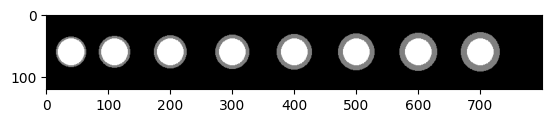

[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.46865588 1.4643111  0.46865588]
[0.46865588 1.4643111  0.46865588]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.22839103 1.24341329 1.24341329 0.22839103]
[0.2283910

True

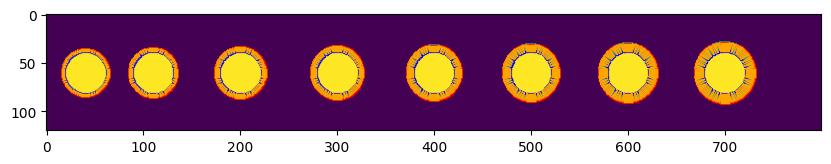

In [43]:
w = 6
# circle2 = simulate_circle(w)
circle2 = simulate_circles()

ext, int, circle2 = detect_contours(circle2)
width, color_map, new_angles = transform1(circle2, ext, int)

k=0.7
signal_second = formula_second(circle2, new_angles, color_map, k, 'signal_circles.png', '.')
# cv2.imwrite(f'signal_circle_{w}_{k}.png', signal_second.astype(np.uint8))
cv2.imwrite(f'signal_circles_{k}.png', signal_second.astype(np.uint8))

# plt.imshow(signal_second)

Text(0.5, 1.0, 'new_angles')

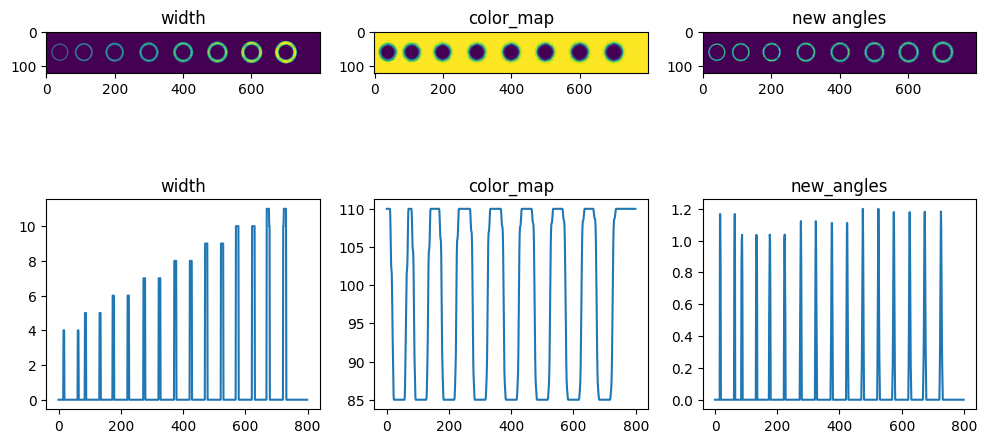

In [45]:
y = 60

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0,0].imshow(width)
ax[0,0].set_title(f'width')

ax[0,1].imshow(color_map)
ax[0,1].set_title(f'color_map')

ax[0,2].imshow(new_angles)
ax[0,2].set_title(f'new angles')

ax[1,1].plot(color_map[y, :])

ax[1,0].plot(width[y, :])
ax[1,0].set_title(f'width')
ax[1,1].set_title(f'color_map')

ax[1,2].plot(new_angles[y, :])
ax[1,2].set_title(f'new_angles')

In [46]:
new_angles[60:61, 600:700]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.16945778, 0.4382413 , 0.8423914 ,
        1.1776755 , 1.1776755 , 0.8423914 , 0.44504464, 0.20347439,
        0.11462576, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.12641901,
        0.22342773, 0.4245003 , 0.7455345 , 1.06

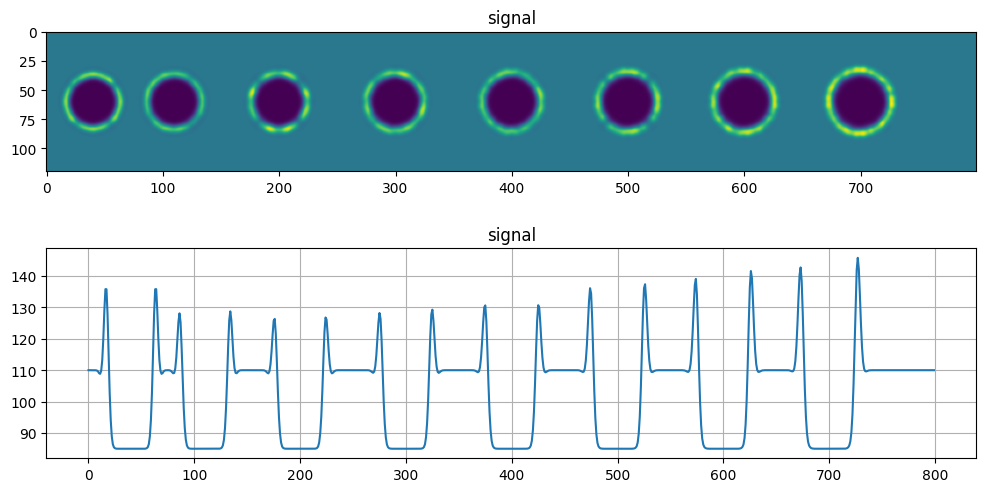

In [47]:
y = 60

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].imshow(signal_second)
ax[0].set_title(f'signal')

ax[1].plot(signal_second[:200, :][y, :])
ax[1].set_title(f'signal')
ax[1].grid()


In [49]:
signal_second[60:61, 650:700]

array([[110.0102  , 110.0102  , 110.0102  , 110.0102  , 110.0102  ,
        110.0102  , 110.0102  , 110.0102  , 110.0102  , 110.00985 ,
        110.00677 , 109.993706, 109.956764, 109.87653 , 109.74741 ,
        109.6226  , 109.72118 , 110.54939 , 112.886086, 117.53402 ,
        124.671326, 133.18544 , 140.33139 , 142.71799 , 138.35974 ,
        128.16809 , 115.44606 , 103.78567 ,  95.24104 ,  90.02299 ,
         87.28841 ,  86.03584 ,  85.47871 ,  85.21765 ,  85.09315 ,
         85.037926,  85.01688 ,  85.01094 ,  85.01    ,  85.00998 ,
         85.00998 ,  85.00998 ,  85.00998 ,  85.00998 ,  85.00998 ,
         85.00998 ,  85.00998 ,  85.00998 ,  85.00998 ,  85.00998 ]],
      dtype=float32)

### make test imgs

In [60]:
img_circles.shape

(120, 800)

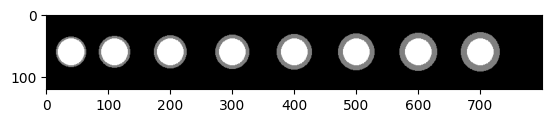

.//signal_test_bezier.png


True

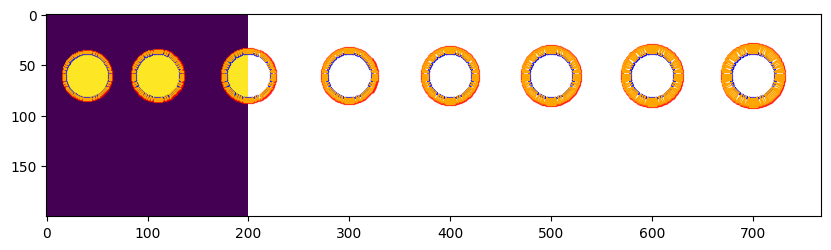

In [28]:
img_circles = simulate_circles()

ext, int, img_circles = detect_contours(img_circles)
width1, color_map1, new_angles1 = transform1(img_circles, ext, int)
# new_angles1 = cv2.GaussianBlur(new_angles1, (3, 3), 0)

signal_second = formula_second(img_circles, new_angles1, color_map1, 0.7, 'signal_test_bezier.png', './')
cv2.imwrite('signal_test_bezier.png', signal_second.astype(np.uint8))

Text(0.5, 1.0, 'new_angles')

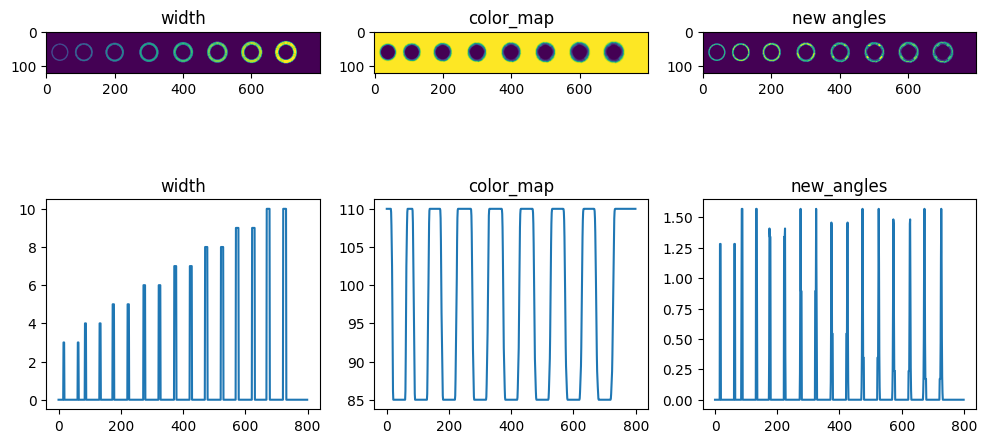

In [62]:
y = 60

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0,0].imshow(width1[:200, :])
ax[0,0].set_title(f'width')

ax[0,1].imshow(color_map1[:200, :])
ax[0,1].set_title(f'color_map')

ax[0,2].imshow(new_angles1[:200, :])
ax[0,2].set_title(f'new angles')

ax[1,0].plot(width1[:200, :][y, :])
ax[1,0].set_title(f'width')

ax[1,1].plot(color_map1[:200, :][y, :])
ax[1,1].set_title(f'color_map')

ax[1,2].plot(new_angles1[:200, :][y, :])
ax[1,2].set_title(f'new_angles')

## random point2 and point3 in bezier

In [142]:
from skimage.draw import line

def bezier2(line, t, prev, color_hole, color_back):
    # print(prev, len(line))
    if prev == 0.0:
        # print('black')
        point1 = (0, color_back)
        point4 = (len(line), color_hole)
        eq = lambda point: ((point - point1[0])/(point4[0] - point1[0]))*(point4[1] - point1[1]) + point1[1]
        x3 = random.randint(0, len(line)-1)
        y3 = random.uniform(color_hole, eq(x3))
        print(x3, y3)
        # point3 = (0, color_hole)
        point3 = (x3, y3)
        x2 = random.randint(1, len(line))
        y2 = random.uniform(eq(x2)+1,color_back)
        print(x2, y2)
        point2 = (x2, y2)
        # point2 = (len(line), color_back)
    if prev == 255.0:
        # print('white')

        point1 = (0, color_hole)
        point4 = (len(line), color_back)
        eq = lambda point: ((point - point1[0])/(point4[0] - point1[0]))*(point4[1] - point1[1]) + point1[1]
        x3 = random.randint(0, len(line)-1)
        y3 = random.uniform(eq(x3), color_back+1)
        print(x3, y3)
        # point3 = (0, color_back)
        point3 = (x3, y3)
        x2 = random.randint(1, len(line))
        y2 = random.uniform(color_hole, eq(x2))
        print(x2, y2)
        point2 = (x2, y2)
        # point2 = (len(line), color_hole)

    # point2 = (len(line), 97.5)
    # point2 = (x2, y2)


    x = point1[0]*(1-t)**3 + point2[0]*3*t*(1-t)**2 + point3[0]*3*t**2*(1-t) + point4[0]*t**3
    vals = point1[1]*(1-t)**3 + point2[1]*3*t*(1-t)**2 + point3[1]*3*t**2*(1-t) + point4[1]*t**3
    
    # fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    # ax.plot(x, vals)
    # plt.set_title('original line, px')

    return x, vals

def transform2(img, ext, int):
    color_back = 110
    color_hole = 85

    width_img = np.zeros_like(img, dtype=np.float32)
    angles_img = np.zeros_like(img, dtype=np.float32)
    new_angles = np.zeros_like(img, dtype=np.float32)
    color_map = np.zeros_like(img, dtype=np.float32)
    color_map[img == 0] = color_back
    color_map[img == 255] = color_hole


    for cont_ext, cont_int in zip(ext, int):
        for point in cont_ext:
                min_dist = float('inf')
                index, dist = closest_point(point, cont_int)
                if dist[index] < min_dist :
                    min_dist = dist[index].item()
                    nearest_point = cont_int[index] 
                    if nearest_point[0] == point[0] and nearest_point[1] == point[1]:
                        dist_ = 1
                    else:
                        dist_ = np.sqrt((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1])**2).astype(np.int32)
                        # print(min_dist, dist_)
                        dist_ = dist_.item()
                dist_ += 1
                
                if dist_ == 0:
                    dist_ = 1
                # print(point, nearest_point)
                # print(zip(*line(*point, *nearest_point)))
                discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
                # discrete_line_x = np.array(list(zip(*discrete_line))[0])
                if len(discrete_line) > 1:
                    mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
                    prev = [compute_previous_pixel(point, nearest_point)]
                    next = [compute_next_pixel(point, nearest_point)]
                # print(next)
                # print(img[prev[0][0], prev[0][1]], len(discrete_line))
                new_line = np.zeros(len(discrete_line)*12, dtype=np.float32)
                x, y = bezier2(new_line, np.linspace(0, 1, len(new_line)), img[prev[0][0], prev[0][1]], color_hole, color_back)
                # print(y)
                angles = np.arctan(np.abs(np.gradient(y, x)))
                draw_gradient_line(color_map, point, discrete_line, y[::12], thickness=3)
                draw_gradient_line(new_angles, point, discrete_line, angles[::12], thickness=3)


                # print(y)
                # angle = np.arctan(700 / (dist_ * 12))
                # cv2.line(width_img, point, nearest_point, dist_, 3)
                # cv2.line(angles_img, point, nearest_point, angle, 2)

                # if len(discrete_line) == 1:
                #     height_vals = [color_back - 2]
                #     discrete_line_ = discrete_line

                # else:
                #     height_vals = [((k_ * ((color_back - color_hole) / dist_)) + color_hole) for k_ in range(0, dist_+2)]
                #     discrete_line_ = discrete_line + next

                # draw_gradient_line(color_map, point, discrete_line_, height_vals, thickness=3)


    for cont_ext, cont_int in zip(ext, int):
        for point in cont_int:
                min_dist = float('inf')
                index, dist = closest_point(point, cont_ext)
                if dist[index] < min_dist :
                    min_dist = dist[index].item()
                    nearest_point = cont_ext[index]
                    if nearest_point[0] == point[0] and nearest_point[1] == point[1]:
                        dist_ = 1
                    else:
                        # print((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1]))
                        dist_ = np.sqrt((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1])**2).astype(np.int32)
                        # print(min_dist, dist_)
                        dist_ = dist_.item()
                dist_ += 1
                if dist_ == 0:
                    dist_ = 1

                # if dist_ > 10:
                #     dist_ = 10
                discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
            
                # discrete_line_x = np.array(list(zip(*discrete_line))[0])
                if len(discrete_line) > 1:
                    mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
                    prev = [compute_previous_pixel(point, nearest_point)]
                    next = [compute_next_pixel(point, nearest_point)]
                # print(img[prev[0][0], prev[0][1]], img[next[0][0], next[0][1]], len(discrete_line))
                # if img[prev[0][0], prev[0][1]] == 128.0:
                #     x, y = bezier(discrete_line, np.linspace(0, len(discrete_line)*12, dtype=np.float32), 255.0, color_hole, color_back)

                # else:
                #     x, y = bezier(discrete_line, np.linspace(0, len(discrete_line)*12, dtype=np.float32), img[prev[0][0], prev[0][1]], color_hole, color_back)
                # # print(y)
                # angles = np.arctan(np.abs(np.gradient(y, x)))
                # draw_gradient_line(color_map, point, discrete_line, y[::12], thickness=3)
                # print(y)

                # angle = np.arctan(700 / (dist_ * 12))
                # cv2.line(width_img, point, nearest_point, dist_, 3)
                # cv2.line(angles_img, point, nearest_point, angle, 2)

                # if len(discrete_line) == 1:
                #     height_vals = [color_back - 2]
                #     discrete_line_ =discrete_line

                # else:
                #     height_vals = [((k_ * ((color_back - color_hole) / dist_)) + color_hole) for k_ in range(1, dist_+2)]
                #     discrete_line_ = discrete_line + next

                # # discrete_line_ =discrete_line + next
                # draw_gradient_line(color_map, point, discrete_line_, height_vals, thickness=3)


                

    mask_width = width_img == 3

    if len(np.unique(mask_width))>1:
    # print(np.unique(new_angles))
        val3 = np.max(new_angles[mask_width])
        new_angles[width_img == 2] = val3*1.001
        new_angles[width_img == 1] = val3*1.002
    else:
        new_angles[width_img == 2] = angles_img[width_img == 2] * 0.9
        new_angles[width_img == 1] = angles_img[width_img == 1] * 0.9

    mask = img != 128 

    width_img[mask] = 0
    angles_img[mask] = 0

    color_map[img == 0] = color_back
    color_map[img == 255] = color_hole

    # mask2 = width_img < 4
    new_angles_copy = new_angles.copy()
    new_angles = cv2.GaussianBlur(new_angles, (7, 7), 0)
    # new_angles[mask2] = new_angles_copy[mask2]
    new_angles[mask] = 0

    color_map = cv2.GaussianBlur(color_map, (5, 5), 0)

    return width_img, color_map, new_angles


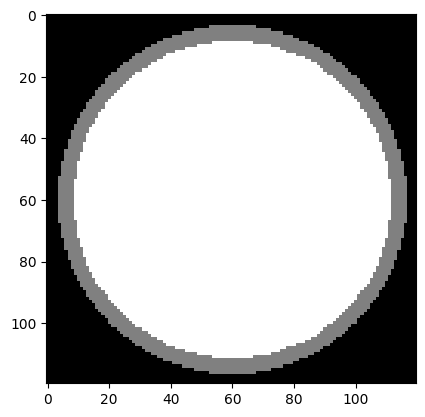

3 93.31511004233997
11 109.20133689682457
8 96.62034498479504
47 103.9166262416897
23 99.16594975156589
25 105.2134244577744
10 93.90935515702876
56 96.28189701339149
1 107.27876836349138
53 103.37751580026392
20 94.45562133232374
22 109.81086068470968
16 102.08307636727213
41 105.15845304562284
51 86.49972256452509
53 97.01325763647328
1 91.86118801332022
58 108.71487636543225
40 92.44857604785241
6 109.0551038867229
26 95.1476066372457
2 110.06206302102888
31 87.1985342982179
58 99.4366147547436
45 85.90363777536187
53 101.16187162402716
12 89.78287575272061
23 108.46191270328234
25 91.75290526869846
38 101.55930179484558
5 94.35696505010644
7 109.01794078180428
55 86.07228811633614
24 102.09902372038164
54 86.10378764481257
3 109.78308663500157
23 86.69115951194075
54 102.28258320380742
9 104.76157616294316
43 98.07003298268025
10 104.24097186521956
1 110.29692849163712
15 90.57772909253679
21 109.00421195062623
1 97.46889811048061
44 93.317720020331
25 96.50339581002322
47 102.2786

Text(0.5, 1.0, 'new_angles')

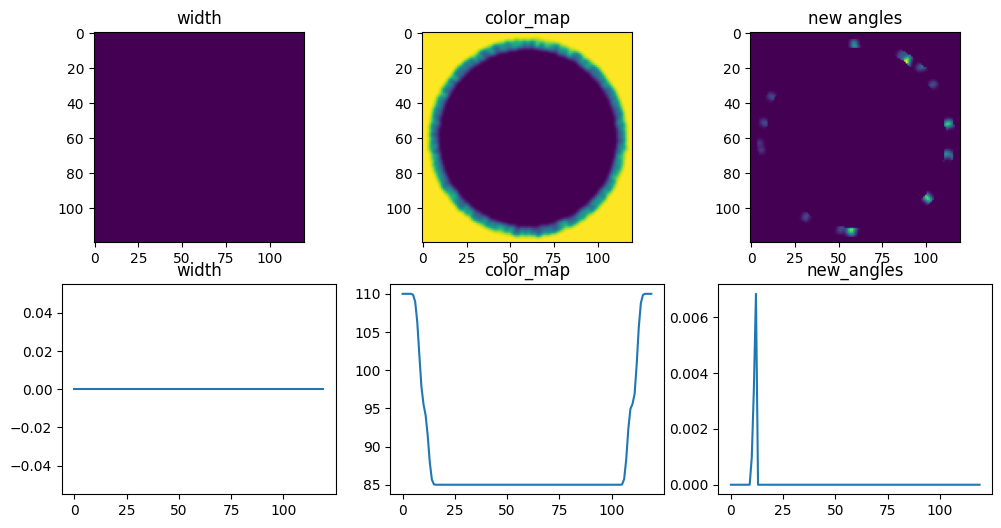

In [143]:
circle2 = simulate_circle(w=5)
ext, int, circle2 = detect_contours(circle2)
width2, color_map2, new_angles2 = transform2(circle2, ext, int)

signal_second2 = formula_second(circle2, new_angles2, color_map2, 3, 'signal_circle2.png', './')
cv2.imwrite('signal_circle.png', signal_second2.astype(np.uint8))

y = 40

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0,0].imshow(width2[:200, :400])
ax[0,0].set_title(f'width')

ax[0,1].imshow(color_map2[:200, :400])
ax[0,1].set_title(f'color_map')

ax[0,2].imshow(new_angles2[:200, :400])
ax[0,2].set_title(f'new angles')

ax[1,0].plot(width2[:200, :400][y, :])
ax[1,0].set_title(f'width')

ax[1,1].plot(color_map2[:200, :400][y, :])
ax[1,1].set_title(f'color_map')

ax[1,2].plot(new_angles2[:200, :400][y, :])
ax[1,2].set_title(f'new_angles')

## test

In [22]:
color_back = 110
color_hole = 85

width_img = np.zeros_like(circle2, dtype=np.float32)

for cont_ext, cont_int in zip(ext, int):
    for point in cont_ext:
            min_dist = float('inf')
            index, dist = closest_point(point, cont_int)
            if dist[index] < min_dist :
                min_dist = dist[index].item()
                nearest_point = cont_int[index] 
                if nearest_point[0] == point[0] and nearest_point[1] == point[1]:
                    dist_ = 1
                else:
                    dist_ = np.sqrt((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1])**2).astype(np.int32)
                    # print(min_dist, dist_)
                    dist_ = dist_.item()
            dist_ += 1
            
            if dist_ == 0:
                dist_ = 1
            discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
            print('color point ', circle2[point[0], point[1]])

            # discrete_line_x = np.array(list(zip(*discrete_line))[0])
            if len(discrete_line) > 1:
                mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
                prev = [compute_previous_pixel(point, nearest_point)]
                next = [compute_next_pixel(point, nearest_point)]
            print('previous ', point, prev)
            print('color previous ', circle2[prev[0][0], prev[0][1]])


            
            # print(next)

            angle = np.arctan(700 / (dist_ * 12))
            cv2.line(width_img, point, nearest_point, dist_, 3)
            # cv2.line(angles_img, point, nearest_point, angle, 2)

            if len(discrete_line) == 1:
                height_vals = [color_back - 2]
                discrete_line_ = discrete_line

            else:
                height_vals = [((k_ * ((color_back - color_hole) / dist_)) + color_hole) for k_ in range(0, dist_+2)]
                discrete_line_ = discrete_line + next

            # draw_gradient_line(color_map, point, discrete_line_, height_vals, thickness=3)

            

for cont_ext, cont_int in zip(ext, int):
    for point in cont_int:
            min_dist = float('inf')
            index, dist = closest_point(point, cont_ext)
            if dist[index] < min_dist :
                min_dist = dist[index].item()
                nearest_point = cont_ext[index]
                if nearest_point[0] == point[0] and nearest_point[1] == point[1]:
                    dist_ = 1
                else:
                    # print((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1]))
                    dist_ = np.sqrt((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1])**2).astype(np.int32)
                    # print(min_dist, dist_)
                    dist_ = dist_.item()
            dist_ += 1
            if dist_ == 0:
                dist_ = 1

            # if dist_ > 10:
            #     dist_ = 10
            discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
            print('color point ', circle2[point[0], point[1]])

            # discrete_line_x = np.array(list(zip(*discrete_line))[0])
            if len(discrete_line) > 1:
                mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
                prev = [compute_previous_pixel(point, nearest_point)]
                next = [compute_next_pixel(point, nearest_point)]

            print('color previous', circle2[prev[0][0], prev[0][1]])

            angle = np.arctan(700 / (dist_ * 12))
            cv2.line(width_img, point, nearest_point, dist_, 3)
            # cv2.line(angles_img, point, nearest_point, angle, 2)

            if len(discrete_line) == 1:
                height_vals = [color_back - 2]
                discrete_line_ =discrete_line

            else:
                height_vals = [((k_ * ((color_back - color_hole) / dist_)) + color_hole) for k_ in range(1, dist_+2)]
                discrete_line_ = discrete_line + next

            # discrete_line_ =discrete_line + next
            # draw_gradient_line(color_map, point, discrete_line_, height_vals, thickness=3)


            
                

mask_width = width_img == 3

# if len(np.unique(mask_width))>1:
#     val3 = np.max(new_angles[mask_width])
#     new_angles[width_img == 2] = val3*1.001
#     new_angles[width_img == 1] = val3*1.002
# else:
#     new_angles[width_img == 2] = angles_img[width_img == 2] * 0.9
#     new_angles[width_img == 1] = angles_img[width_img == 1] * 0.9

mask = circle2 != 128 

width_img[mask] = 0

color point  128.0
previous  [53  4] [(53, 3)]
color previous  0.0
color point  128.0
previous  [54  4] [(54, 3)]
color previous  0.0
color point  128.0
previous  [55  4] [(55, 3)]
color previous  0.0
color point  128.0
previous  [56  4] [(56, 3)]
color previous  0.0
color point  128.0
previous  [57  4] [(57, 3)]
color previous  0.0
color point  128.0
previous  [58  4] [(58, 3)]
color previous  0.0
color point  128.0
previous  [59  4] [(59, 3)]
color previous  0.0
color point  128.0
previous  [60  4] [(60, 3)]
color previous  0.0
color point  128.0
previous  [61  4] [(61, 3)]
color previous  0.0
color point  128.0
previous  [62  4] [(62, 3)]
color previous  0.0
color point  128.0
previous  [63  4] [(63, 3)]
color previous  0.0
color point  128.0
previous  [64  4] [(64, 3)]
color previous  0.0
color point  128.0
previous  [65  4] [(65, 3)]
color previous  0.0
color point  128.0
previous  [66  4] [(66, 3)]
color previous  0.0
color point  128.0
previous  [67  4] [(67, 3)]
color previous 

## original function

In [ ]:
def transform(img, ext, int):
    color_back = 110
    color_hole = 85

    width_img = np.zeros_like(img, dtype=np.float32)
    angles_img = np.zeros_like(img, dtype=np.float32)
    new_angles = np.zeros_like(img, dtype=np.float32)
    color_map = np.zeros_like(img, dtype=np.float32)
    color_map[img == 0] = color_back
    color_map[img == 255] = color_hole


    for cont_ext, cont_int in zip(ext, int):
        for point in cont_ext:
                min_dist = float('inf')
                index, dist = closest_point(point, cont_int)
                if dist[index] < min_dist :
                    min_dist = dist[index].item()
                    nearest_point = cont_int[index] 
                    if nearest_point[0] == point[0] and nearest_point[1] == point[1]:
                        dist_ = 1
                    else:
                        dist_ = np.sqrt((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1])**2).astype(np.int32)
                        # print(min_dist, dist_)
                        dist_ = dist_.item()
                dist_ += 1
                
                if dist_ == 0:
                    dist_ = 1
                discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
                # discrete_line_x = np.array(list(zip(*discrete_line))[0])
                if len(discrete_line) > 1:
                    mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
                    prev = [compute_previous_pixel(point, nearest_point)]
                    next = [compute_next_pixel(point, nearest_point)]
                # print(next)

                angle = np.arctan(700 / (dist_ * 12))
                cv2.line(width_img, point, nearest_point, dist_, 3)
                cv2.line(angles_img, point, nearest_point, angle, 2)

                if len(discrete_line) == 1:
                    height_vals = [color_back - 2]
                    discrete_line_ = discrete_line

                else:
                    height_vals = [((k_ * ((color_back - color_hole) / dist_)) + color_hole) for k_ in range(0, dist_+2)]
                    discrete_line_ = discrete_line + next

                draw_gradient_line(color_map, point, discrete_line_, height_vals, thickness=3)

                # calculate new angles
                if dist_ >= 3:

                    # firct variant

                    # if dist_ > 5:
                        k = dist_/10
                        # if k > 1:
                        # print(dist, k, angle)
                        # if k < 1:
                        #     val = angle*k
                        # else:
                        #     val = angle/k
                        val = angle * 0.9

                        y_mean = val
                        y_0 = val/2
                        y_n = val/2
                        x_plot = np.arange(0, len(discrete_line))
                        coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2], x_plot[-1]], [y_0, y_mean, y_n])
                        a,b,c = coefs[0]
                        y_parabola = parabola(x_plot, a, b, c)
                        heights = y_parabola
                        draw_gradient_line(new_angles, point, discrete_line, np.abs(y_parabola), thickness=5)
                    # else:
                    #     val = angle
                    #     cv2.line(new_angles, point, nearest_point, val, 4)
                    # val = np.arctan(700/(dist_+2))*0.9

                    # if dist_ <= 5:
                    #     k = dist_/10
                    #     val = np.abs(angle*(1-k) * 0.95)

                    #     # val = angle*(1-k) * 0.95
                    # else:
                    #     k = dist_/5
                    # val = np.abs(angle*(1-k) * 0.95)
                    # if k < 1:
                    #     val = angle*(1-k) * 0.95
                        # val = angle/k * 0.95

                    # else:
                        # val = angle/k * 0.95


                    # ___ added - плохо видно широкую границу 9-10 пикселей

                    # if dist_ > 6:
                        # dist_ = 6
                    # k = (dist_-2)/10
                    # val = angle * (1 - k)
                    # val = angle * (1 - k)

                    # another add
                    # val = 0.9 * angle

                    # added second - пытаюсь улучшить видимость широкой границы
                    # if dist_>=8:
                    #     val = val * 1.1
                    # print(dist_, angle, k, val)

                    # y_mean = val
                    # y_0 = val/2
                    # y_n = val/2
                    # y_0 = val/6
                    # y_n = val/6
                    # x_plot = np.arange(0, len(discrete_line)+2)
                    # x_plot = np.arange(0, len(discrete_line))

                    # x_plot = np.arange(0, len(discrete_line)+1)

                    # coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2], x_plot[-1]], [y_0, y_mean, y_n])
                    # coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2 - 1], x_plot[-1]], [y_0, y_mean, y_n])
                    # coefs = curve_fit(parabola, [x_plot[0], x_plot[1], x_plot[len(x_plot)//2 - 1], x_plot[-2], x_plot[-1]], [0, y_0, y_mean, y_n, 0])


                    # a,b,c = coefs[0]
                    # y_parabola = parabola(x_plot, a, b, c)
                    # y_parabola = blur(y_parabola)
                    # y_parabola =  gaussian_filter1d(y_parabola, 3)
                    # heights = y_parabola
                    # if dist_ > 10:
                    #     thickness = 5
                    # else:
                    #     thickness = 5
                    # discrete_line_ = prev + discrete_line + next
                    # discrete_line_ = discrete_line

                    # discrete_line_ = prev + discrete_line

                    # draw_gradient_line(new_angles, point, discrete_line_, y_parabola, thickness=thickness)


    for cont_ext, cont_int in zip(ext, int):
        for point in cont_int:
                min_dist = float('inf')
                index, dist = closest_point(point, cont_ext)
                if dist[index] < min_dist :
                    min_dist = dist[index].item()
                    nearest_point = cont_ext[index]
                    if nearest_point[0] == point[0] and nearest_point[1] == point[1]:
                        dist_ = 1
                    else:
                        # print((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1]))
                        dist_ = np.sqrt((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1])**2).astype(np.int32)
                        # print(min_dist, dist_)
                        dist_ = dist_.item()
                dist_ += 1
                if dist_ == 0:
                    dist_ = 1

                # if dist_ > 10:
                #     dist_ = 10
                discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
                # discrete_line_x = np.array(list(zip(*discrete_line))[0])
                if len(discrete_line) > 1:
                    mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
                    prev = [compute_previous_pixel(point, nearest_point)]
                    next = [compute_next_pixel(point, nearest_point)]

                angle = np.arctan(700 / (dist_ * 12))
                cv2.line(width_img, point, nearest_point, dist_, 3)
                cv2.line(angles_img, point, nearest_point, angle, 2)

                if len(discrete_line) == 1:
                    height_vals = [color_back - 2]
                    discrete_line_ =discrete_line

                else:
                    height_vals = [((k_ * ((color_back - color_hole) / dist_)) + color_hole) for k_ in range(1, dist_+2)]
                    discrete_line_ = discrete_line + next

                # discrete_line_ =discrete_line + next
                draw_gradient_line(color_map, point, discrete_line_, height_vals, thickness=3)


                # calculate new angles
                if dist_ >= 3:

                    # firct variant

                    # if dist_ > 5:
                    #     k = dist_/10
                    #     # if k > 1:
                    #     # print(dist, k, angle)
                    #     if k < 1:
                    #         val = angle*k
                    #     else:
                    #         val = angle/k

                        val = angle * 0.9
                        y_mean = val
                        y_0 = val/2
                        y_n = val/2
                        x_plot = np.arange(0, len(discrete_line))
                        coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2], x_plot[-1]], [y_0, y_mean, y_n])
                        a,b,c = coefs[0]
                        y_parabola = parabola(x_plot, a, b, c)
                        heights = y_parabola
                        draw_gradient_line(new_angles, point, discrete_line, np.abs(y_parabola), thickness=5)
                    # else:
                    #     val = angle
                    #     cv2.line(new_angles, point, nearest_point, val, 4)

                    # val = np.arctan(700/(dist_+2))*0.9

                    # if dist_ <= 5:
                    #     k = dist_/10
                    #     val = np.abs(angle*(1-k) * 0.95)

                    #     # val = angle*(1-k) * 0.95
                    # else:
                    #     k = dist_/5
                    # val = np.abs(angle*(1-k) * 0.95)
                    # if k < 1:
                    #     val = angle*(1-k) * 0.95
                        # val = angle/k * 0.95

                    # else:
                        # val = angle/k * 0.95


                    # ___ added - плохо видно широкую границу 9-10 пикселей

                    # if dist_ > 6:
                        # dist_ = 6
                    # k = (dist_-2)/10
                    # val = angle * (1 - k)
                    # val = angle * (1 - k)

                    # another add
                    # val = 0.9 * angle

                    # added second - пытаюсь улучшить видимость широкой границы
                    # if dist_>=8:
                    #     val = val * 1.1
                    # val = angle * 0.9
                    # print(dist_, angle, k, val)

                    # y_mean = val
                    # y_0 = val/2
                    # y_n = val/2
                    
                    # y_0 = val/6
                    # y_n = val/6
                    # x_plot = np.arange(0, len(discrete_line)+2)
                    # x_plot = np.arange(0, len(discrete_line))

                    # x_plot = np.arange(0, len(discrete_line)+1)

                    # coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2], x_plot[-1]], [y_0, y_mean, y_n])
                    # coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2 - 1], x_plot[-1]], [y_0, y_mean, y_n])

                    # coefs = curve_fit(parabola, [x_plot[0], x_plot[1], x_plot[len(x_plot)//2 - 1], x_plot[-2], x_plot[-1]], [0, y_0, y_mean, y_n, 0])


                    # a,b,c = coefs[0]
                    # y_parabola = parabola(x_plot, a, b, c)

                    # if dist_ > 10:
                    #     thickness = 5
                    # else:
                    #     thickness = 3
                    
                    # # discrete_line_ = prev + discrete_line + next
                    # discrete_line_ = discrete_line

                    # # discrete_line_ = prev + discrete_line

                    # draw_gradient_line(new_angles, point, discrete_line_, y_parabola, thickness=thickness)

    # print(np.unique(width_img == 3))
    # print(np.unique(width_img))
    mask_width = width_img == 3

    if len(np.unique(mask_width))>1:
    # print(np.unique(new_angles))
        val3 = np.max(new_angles[mask_width])
        new_angles[width_img == 2] = val3*1.001
        new_angles[width_img == 1] = val3*1.002
    else:
        new_angles[width_img == 2] = angles_img[width_img == 2] * 0.9
        new_angles[width_img == 1] = angles_img[width_img == 1] * 0.9

    mask = img != 128 

    width_img[mask] = 0
    angles_img[mask] = 0

    color_map[img == 0] = color_back
    color_map[img == 255] = color_hole

    # mask2 = width_img < 4
    new_angles_copy = new_angles.copy()
    new_angles = cv2.GaussianBlur(new_angles, (7, 7), 0)
    # new_angles[mask2] = new_angles_copy[mask2]
    new_angles[mask] = 0
    angles_img = cv2.GaussianBlur(angles_img, (7, 7), 0)
    # angles_img = cv2.GaussianBlur(angles_img, (3, 3), 0)

    color_map = cv2.GaussianBlur(color_map, (7, 7), 0)

    # return width_img, angles_img, new_angles, color_map
    return width_img


In [ ]:
def get_width(img, ext, int):
    color_back = 110
    color_hole = 85

    width_img = np.zeros_like(img, dtype=np.float32)
    # angles_img = np.zeros_like(img, dtype=np.float32)
    # new_angles = np.zeros_like(img, dtype=np.float32)
    # color_map = np.zeros_like(img, dtype=np.float32)
    # color_map[img == 0] = color_back
    # color_map[img == 255] = color_hole


    for cont_ext, cont_int in zip(ext, int):
        for point in cont_ext:
                min_dist = float('inf')
                index, dist = closest_point(point, cont_int)
                if dist[index] < min_dist :
                    min_dist = dist[index].item()
                    nearest_point = cont_int[index] 
                    if nearest_point[0] == point[0] and nearest_point[1] == point[1]:
                        dist_ = 1
                    else:
                        dist_ = np.sqrt((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1])**2).astype(np.int32)
                        # print(min_dist, dist_)
                        dist_ = dist_.item()
                dist_ += 1
                
                if dist_ == 0:
                    dist_ = 1
                discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
                # discrete_line_x = np.array(list(zip(*discrete_line))[0])
                if len(discrete_line) > 1:
                    mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
                    prev = [compute_previous_pixel(point, nearest_point)]
                    next = [compute_next_pixel(point, nearest_point)]
                # print(next)

                angle = np.arctan(700 / (dist_ * 12))
                cv2.line(width_img, point, nearest_point, dist_, 3)
                cv2.line(angles_img, point, nearest_point, angle, 2)

                if len(discrete_line) == 1:
                    height_vals = [color_back - 2]
                    discrete_line_ = discrete_line

                else:
                    height_vals = [((k_ * ((color_back - color_hole) / dist_)) + color_hole) for k_ in range(0, dist_+2)]
                    discrete_line_ = discrete_line + next

                draw_gradient_line(color_map, point, discrete_line_, height_vals, thickness=3)

                

    for cont_ext, cont_int in zip(ext, int):
        for point in cont_int:
                min_dist = float('inf')
                index, dist = closest_point(point, cont_ext)
                if dist[index] < min_dist :
                    min_dist = dist[index].item()
                    nearest_point = cont_ext[index]
                    if nearest_point[0] == point[0] and nearest_point[1] == point[1]:
                        dist_ = 1
                    else:
                        # print((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1]))
                        dist_ = np.sqrt((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1])**2).astype(np.int32)
                        # print(min_dist, dist_)
                        dist_ = dist_.item()
                dist_ += 1
                if dist_ == 0:
                    dist_ = 1

                # if dist_ > 10:
                #     dist_ = 10
                discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
                # discrete_line_x = np.array(list(zip(*discrete_line))[0])
                if len(discrete_line) > 1:
                    mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
                    prev = [compute_previous_pixel(point, nearest_point)]
                    next = [compute_next_pixel(point, nearest_point)]

                angle = np.arctan(700 / (dist_ * 12))
                cv2.line(width_img, point, nearest_point, dist_, 3)
                cv2.line(angles_img, point, nearest_point, angle, 2)

                if len(discrete_line) == 1:
                    height_vals = [color_back - 2]
                    discrete_line_ =discrete_line

                else:
                    height_vals = [((k_ * ((color_back - color_hole) / dist_)) + color_hole) for k_ in range(1, dist_+2)]
                    discrete_line_ = discrete_line + next

                # discrete_line_ =discrete_line + next
                draw_gradient_line(color_map, point, discrete_line_, height_vals, thickness=3)


                
                    

    mask_width = width_img == 3

    if len(np.unique(mask_width))>1:
        val3 = np.max(new_angles[mask_width])
        new_angles[width_img == 2] = val3*1.001
        new_angles[width_img == 1] = val3*1.002
    else:
        new_angles[width_img == 2] = angles_img[width_img == 2] * 0.9
        new_angles[width_img == 1] = angles_img[width_img == 1] * 0.9

    mask = img != 128 

    width_img[mask] = 0

    return width_img
